In [46]:
import seaborn as sns
import pandas as pd
import numpy as np
import re
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")



# Salary Insights Preparation

Prepare a clean and reliable subset of the dataset focused on salary calculations and compensation analysis.
•	Salary values exist in multiple formats (annual, hourly).
•	Many rows have missing or partial salary information.
•	salary_rate may need normalization (“yr”, “hr”, “annually”, etc.).
•	Outliers or invalid salary values may distort insights.
## Key Questions This Wrangling Should Answer
•	What is the distribution of salaries across job roles?
•	How do salaries vary by location or job type?
•	Are remote jobs paid differently from on-site roles?
•	What percent of postings disclose salary information?


## LOAD DATA FROM EXCEL WORKBOOK

In [47]:
def load_df():
    # file path
    file = "data/data_jobs_salary_monthly.xlsx"
    # names of the sheets
    months = ["Jan","Feb","Mar","Apr","May","Jun",
              "Jul","Aug","Sep","Oct","Nov","Dec"]
    # load data from excel sheets into the DataFrame 
    df_list = [pd.read_excel(file, sheet_name=m) for m in months]
    
    df = pd.concat(df_list, axis=0, ignore_index=True)
    return df
 

In [48]:
df = load_df()
df.head()

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills
0,Data Scientist,Data Scientist - TikTok Ads,"Mountain View, CA",via LinkedIn,Full-time,False,"California, United States",2023-01-02 15:01:03,False,True,United States,year,224500.0,NaN,TikTok,"['r', 'python', 'matlab', 'sql']"
1,Data Scientist,Data Scientist - Technical Platform,"Mountain View, CA",via LinkedIn,Full-time,False,"California, United States",2023-01-12 04:04:48,False,True,United States,year,157500.0,NaN,TikTok,"['sql', 'python']"
2,Data Scientist,Data Scientist - Computer Vision,"Paris, France",via Ai-Jobs.net,Full-time,False,France,2023-01-30 08:13:55,False,False,France,year,88128.0,NaN,digiRocks,"['python', 'c++', 'pytorch', 'tensorflow', 'ke..."
3,Data Scientist,Senior Actuarial Consultant and Data Scientist...,"Las Vegas, NV","via Las Vegas, NV - Geebo",Full-time,False,"California, United States",2023-01-27 00:05:41,False,True,United States,hour,NaN,24.0,UnitedHealth Group,"['r', 'python', 'vba', 'sas', 'sas', 'sql', 'd..."
4,Data Scientist,Data Scientist Digital Effectiveness Operation...,"Sun City, AZ",via ZipRecruiter,Full-time,False,"California, United States",2023-01-29 10:04:53,False,True,United States,year,105800.0,NaN,Cox Communications,"['sql', 'python', 'aws', 'pandas', 'numpy', 's..."


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32672 entries, 0 to 32671
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   job_title_short        32672 non-null  object        
 1   job_title              32672 non-null  object        
 2   job_location           32317 non-null  object        
 3   job_via                32662 non-null  object        
 4   job_schedule_type      32531 non-null  object        
 5   job_work_from_home     32672 non-null  bool          
 6   search_location        32672 non-null  object        
 7   job_posted_date        32672 non-null  datetime64[ns]
 8   job_no_degree_mention  32672 non-null  bool          
 9   job_health_insurance   32672 non-null  bool          
 10  job_country            32672 non-null  object        
 11  salary_rate            32672 non-null  object        
 12  salary_year_avg        22036 non-null  float64       
 13  s

### JOB DOMAIN INFORMATION

In [50]:
def extract_job_domain(row):
    # If "-" exists, split and check first part
    if '-' in row['job_title']:
        first_part, second_part = map(str.strip, row['job_title'].split('-', 1))
        # Only take second part if first part matches job_title_short
        if first_part in df['job_title_short'].values:
            return second_part
    # If no "-" or first part invalid, keep original job_title
    return row['job_title']

# Apply to create job_domain column
df['job_domain'] = df.apply(extract_job_domain, axis=1)


When you use *_df.apply(function_name, axis=1)_*, pandas passes each row as a Series object to your function. The parameter name (here, row) can be anything you choose - it represents one entire row of the DataFrame

split('-', 1): Split the string at the first dash only (maxsplit=1).

map(str.strip, ...): Apply strip() to remove whitespace from both resulting parts

***Syntax: DataFrame.apply(function, axis)***

***- axis=0: Apply function to each COLUMN (default)***

***- axis=1: Apply function to each ROW  ← This is what we're using***

In [54]:
# Get current column order
cols = df.columns.tolist()
# Remove 'job_domain' from its current position
cols.remove('job_domain')
# Insert 'job_domain' right after the first column (index 1)
cols.insert(1, 'job_domain')
# Reorder the DataFrame
df_domain = df[cols]
df_domain.head(15)

,job_title_short,job_domain,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills
0,Data Scientist,TikTok Ads,Data Scientist - TikTok Ads,"Mountain View, CA",via LinkedIn,Full-time,False,"California, United States",2023-01-02 15:01:03,False,True,United States,year,224500.0,NaN,TikTok,"['r', 'python', 'matlab', 'sql']"
1,Data Scientist,Technical Platform,Data Scientist - Technical Platform,"Mountain View, CA",via LinkedIn,Full-time,False,"California, United States",2023-01-12 04:04:48,False,True,United States,year,157500.0,NaN,TikTok,"['sql', 'python']"
2,Data Scientist,Computer Vision,Data Scientist - Computer Vision,"Paris, France",via Ai-Jobs.net,Full-time,False,France,2023-01-30 08:13:55,False,False,France,year,88128.0,NaN,digiRocks,"['python', 'c++', 'pytorch', 'tensorflow', 'ke..."
3,Data Scientist,Senior Actuarial Consultant and Data Scientist...,Senior Actuarial Consultant and Data Scientist...,"Las Vegas, NV","via Las Vegas, NV - Geebo",Full-time,False,"California, United States",2023-01-27 00:05:41,False,True,United States,hour,NaN,24.0,UnitedHealth Group,"['r', 'python', 'vba', 'sas', 'sas', 'sql', 'd..."
4,Data Scientist,Data Scientist Digital Effectiveness Operation...,Data Scientist Digital Effectiveness Operation...,"Sun City, AZ",via ZipRecruiter,Full-time,False,"California, United States",2023-01-29 10:04:53,False,True,United States,year,105800.0,NaN,Cox Communications,"['sql', 'python', 'aws', 'pandas', 'numpy', 's..."
5,Data Scientist,Marketing Analytics,Data Scientist - Marketing Analytics,"Irving, TX",via LinkedIn,Full-time,False,"Texas, United States",2023-01-24 16:02:05,False,True,United States,year,115000.0,NaN,Cottonwood Financial,"['sql', 'sas', 'sas', 'python', 'r']"
6,Senior Data Analyst,Senior Data Analyst Business Optimization Inte...,Senior Data Analyst Business Optimization Inte...,"Bailey's Crossroads, VA",via ZipRecruiter,Full-time,False,"New York, United States",2023-01-04 10:00:41,False,True,United States,year,96500.0,NaN,Cox Communications,"['sql', 'snowflake', 'aws', 'microstrategy', '..."
7,Data Engineer,IT & Strategy Talent Programme - AI/ML and Dat...,IT & Strategy Talent Programme - AI/ML and Dat...,"Hamburg, Germany",via Ai-Jobs.net,Full-time,False,Germany,2023-01-12 20:44:40,False,False,Germany,year,98301.5,NaN,Vattenfall,['azure']
8,Senior Data Scientist,Senior Data Scientist,Senior Data Scientist,"El Mirage, AZ",via ZipRecruiter,Full-time,False,"California, United States",2023-01-29 10:04:52,False,True,United States,year,116700.0,NaN,Cox Communications,"['sql', 'r', 'python', 'scala', 'java', 'c++',..."
9,Data Engineer,Data Engineer,Data Engineer,"Chicago, IL",via Indeed,Full-time,False,"California, United States",2023-01-13 19:09:10,False,True,United States,year,102500.0,NaN,Alliant Credit Union,"['sql', 'azure', 'tableau']"


## Salary Data Wrangling — Clean Annual Salaries

In [79]:
def wrangle_year():
    # Remove the "via " prefix if it exists
    df_domain['job_via'] = df_domain['job_via'].str.replace(r'^via\s+', '', regex=True)
    
    # Select only the columns needed for salary analysis
    salary_cols = [
        'job_title_short',   
        'job_domain',      
        'job_location',      
        'job_via',           # source
        'job_schedule_type', 
        'job_work_from_home',
        'job_no_degree_mention',
        'job_country',
        'salary_rate',
        'salary_year_avg',   # keep only annual salary
        'company_name',
        'job_skills'
    ]
    df_salary = df_domain[salary_cols].copy()
    
    # Drop rows where critical columns are missing
    required_cols = [
        'salary_year_avg',
        'job_title_short',
        'job_location',
        'job_work_from_home',
        'job_country',
        'salary_rate',
        'job_schedule_type'
    ]
    df_salary = df_salary.dropna(subset=required_cols)
    df_salary['salary_year_avg'] = df_salary['salary_year_avg'].astype(int)
    return df_salary


In [80]:
annual_sal_df = wrangle_year()

In [58]:
annual_sal_df.head()

,job_title_short,job_domain,job_location,job_via,job_schedule_type,job_work_from_home,job_no_degree_mention,job_country,salary_rate,salary_year_avg,company_name,job_skills
0,Data Scientist,TikTok Ads,"Mountain View, CA",LinkedIn,Full-time,False,False,United States,year,224500.0,TikTok,"['r', 'python', 'matlab', 'sql']"
1,Data Scientist,Technical Platform,"Mountain View, CA",LinkedIn,Full-time,False,False,United States,year,157500.0,TikTok,"['sql', 'python']"
2,Data Scientist,Computer Vision,"Paris, France",Ai-Jobs.net,Full-time,False,False,France,year,88128.0,digiRocks,"['python', 'c++', 'pytorch', 'tensorflow', 'ke..."
4,Data Scientist,Data Scientist Digital Effectiveness Operation...,"Sun City, AZ",ZipRecruiter,Full-time,False,False,United States,year,105800.0,Cox Communications,"['sql', 'python', 'aws', 'pandas', 'numpy', 's..."
5,Data Scientist,Marketing Analytics,"Irving, TX",LinkedIn,Full-time,False,False,United States,year,115000.0,Cottonwood Financial,"['sql', 'sas', 'sas', 'python', 'r']"


In [81]:
annual_sal_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21741 entries, 0 to 32667
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   job_title_short        21741 non-null  object
 1   job_domain             21741 non-null  object
 2   job_location           21741 non-null  object
 3   job_via                21741 non-null  object
 4   job_schedule_type      21741 non-null  object
 5   job_work_from_home     21741 non-null  bool  
 6   job_no_degree_mention  21741 non-null  bool  
 7   job_country            21741 non-null  object
 8   salary_rate            21741 non-null  object
 9   salary_year_avg        21741 non-null  int64 
 10  company_name           21741 non-null  object
 11  job_skills             19945 non-null  object
dtypes: bool(2), int64(1), object(9)
memory usage: 1.9+ MB


In [61]:
annual_sal_df['salary_rate'].unique()

array(['year'], dtype=object)

In [82]:
def wrangle_hour():
    # Remove the "via " prefix if it exists
    df_domain['job_via'] = df_domain['job_via'].str.replace(r'^via\s+', '', regex=True)
    
    # Select only the columns needed for salary analysis
    salary_cols = [
        'job_title_short',   
        'job_domain',      
        'job_location',      
        'job_via',           # source
        'job_schedule_type', 
        'job_work_from_home',
        'job_no_degree_mention',
        'job_country',
        'salary_rate',
        'salary_hour_avg',   # keep only annual salary
        'company_name',
        'job_skills'
    ]
    df_salary = df_domain[salary_cols].copy()

    
    # Drop rows where critical columns are missing
    required_cols = [
        'salary_hour_avg',
        'job_title_short',
        'job_location',
        'job_work_from_home',
        'job_country',
        'salary_rate',
        'job_schedule_type'
    ]
    # drop null values
    df_salary = df_salary.dropna(subset=required_cols)
    # recast the Salary to int
    df_salary['salary_hour_avg'] = df_salary['salary_hour_avg'].astype(int)
    return df_salary
hour_salary_df = wrangle_hour()

In [83]:
hour_salary_df.head(10)

,job_title_short,job_domain,job_location,job_via,job_schedule_type,job_work_from_home,job_no_degree_mention,job_country,salary_rate,salary_hour_avg,company_name,job_skills
3,Data Scientist,Senior Actuarial Consultant and Data Scientist...,"Las Vegas, NV","Las Vegas, NV - Geebo",Full-time,False,False,United States,hour,24,UnitedHealth Group,"['r', 'python', 'vba', 'sas', 'sas', 'sql', 'd..."
22,Data Scientist,Electronics Data Scientist Intern,Anywhere,Indeed,Full-time,True,False,United States,hour,21,MilliporeSigma,"['excel', 'outlook']"
23,Data Scientist,"Data Scientist (Genomics/Genetics, Python, AWS...",Anywhere,LinkedIn,Contractor,True,False,United States,hour,66,neteffects,"['python', 'r', 'sql', 'java', 'aws', 'gcp', '..."
24,Senior Data Analyst,Senior Data Analyst,"Ontario, CA",Indeed,Full-time,False,False,United States,hour,34,Prime Healthcare Management Inc,"['sql', 'excel']"
33,Data Scientist,Mathematics Statistician or Statistician (Data...,"Buffalo, NY","Buffalo, NY - Geebo",Full-time,False,False,United States,hour,24,Internal Revenue Service,"['c', 'r', 'python', 'sql', 'java', 'oracle']"
40,Senior Data Scientist,ProServe,"Lakeland, FL","Lakeland, FL - Geebo",Full-time,False,False,United States,hour,24,"Amazon Web Services, Inc.","['aws', 'mxnet', 'tensorflow', 'pytorch', 'sci..."
51,Data Engineer,Big Data Engineer,"Malvern, PA",LinkedIn,Contractor,False,False,United States,hour,61,Robert Half,"['sql', 'go', 'snowflake', 'ssis']"
59,Senior Data Engineer,AWS Senior Cloud Data Engineer,Anywhere,Upwork,Contractor,True,True,United States,hour,16,Upwork,"['aws', 'redshift', 'git']"
67,Data Analyst,SQL Developer/Data Analyst,"New York, NY",Dice,Contractor,False,False,United States,hour,60,Infosight Consulting Inc,"['sql', 'python', 'sql server', 'oracle']"
69,Data Analyst,Data Analyst with FinTech-,"Austin, TX","Austin, TX - Geebo",Full-time,False,True,United States,hour,24,EXPERIS,"['sql', 'snowflake']"


In [84]:
hour_salary_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10435 entries, 3 to 32671
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   job_title_short        10435 non-null  object
 1   job_domain             10435 non-null  object
 2   job_location           10435 non-null  object
 3   job_via                10425 non-null  object
 4   job_schedule_type      10435 non-null  object
 5   job_work_from_home     10435 non-null  bool  
 6   job_no_degree_mention  10435 non-null  bool  
 7   job_country            10435 non-null  object
 8   salary_rate            10435 non-null  object
 9   salary_hour_avg        10435 non-null  int64 
 10  company_name           10435 non-null  object
 11  job_skills             9095 non-null   object
dtypes: bool(2), int64(1), object(9)
memory usage: 917.1+ KB


## DATA ANALYSIS

### summary Statistics

***HOURLY***

In [86]:
summary_stats = hour_salary_df['salary_hour_avg'].describe()
print(summary_stats)

count    10435.000000
mean        46.684811
std         21.804462
min          8.000000
25%         27.000000
50%         45.000000
75%         61.000000
max        391.000000
Name: salary_hour_avg, dtype: float64


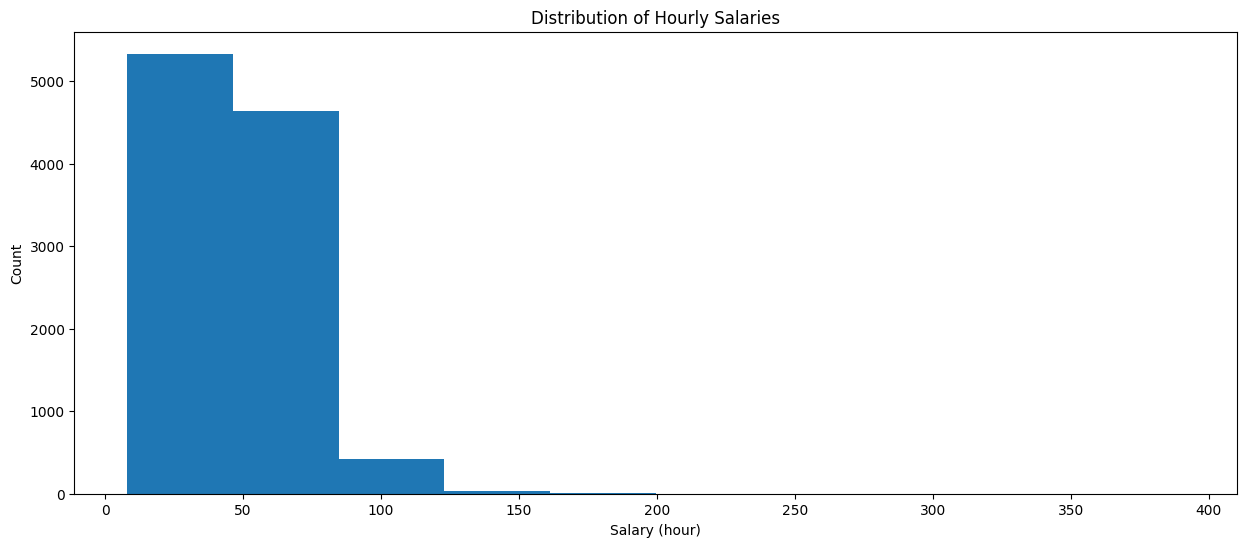

In [91]:
plt.figure(figsize=(15,6))
plt.hist(hour_salary_df['salary_hour_avg'])
plt.title('Distribution of Hourly Salaries')
plt.xlabel('Salary (hour)')
plt.ylabel('Count')
plt.show()


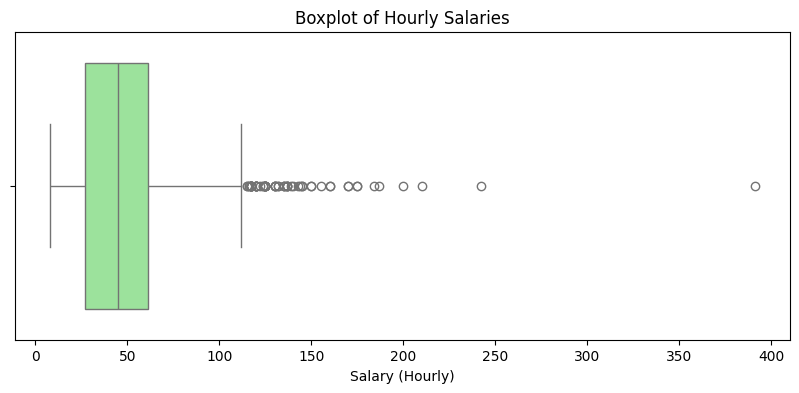

In [92]:
plt.figure(figsize=(10,4))
sns.boxplot(x=hour_salary_df['salary_hour_avg'], color='lightgreen')
plt.title('Boxplot of Hourly Salaries')
plt.xlabel('Salary (Hourly)')
plt.show()


In [95]:
#  identify outliers
(hour_salary_df['salary_hour_avg'] > 250) == True

3        False
22       False
23       False
24       False
33       False
         ...  
32666    False
32668    False
32669    False
32670    False
32671    False
Name: salary_hour_avg, Length: 10435, dtype: bool